## Part 1: Data Processing

### Packages

In [164]:
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
stop_words = stopwords.words('english')
stemmer = PorterStemmer()
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report
from collections import Counter

### Functions

In [165]:
import pandas as pd
import re

strange_double_quotes = ["«","‹","»","›","„","“","‟","”","❝","❞","❮","❯","〝","〞","〟","＂",]
strange_single_quotes = ["‘", "‛", "’", "❛", "❜", "`", "´", "‘", "’"]

double_quotes= re.compile("|".join(strange_double_quotes))
single_quotes= re.compile("|".join(strange_single_quotes))

def clean_text_2(text):

    #fix quotation marks
    text = double_quotes.sub('"', text)
    text = single_quotes.sub("'", text)
    
    #Standardise case
    text = text.lower()

    #remove numbers, URLS, emails and dates
    text = re.sub(r'http[^\s]*','URL', text)
    text = re.sub(r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', 'EMAIL', text)
    text = re.sub(r'([\w]+[ \.]+[\d]{,2}, [\d]{4})|(\d{4}-\d{2}-\d{2})','DATE',text)
    text = re.sub(r'[\d]{2}:[\d]{2}:[\d]{2}(.[\d]+)?','TIME',text)
    text = re.sub(r'\d+','NUM',text)

    #Replace punctuation with whitespaces
    text = re.sub(r"""[,.:'"\[\]\(\)]""", ' ', text)
    text = re.sub(r'-', '', text)

    #Normalize whitespaces
    text = re.sub(r'\n{1,}',' ',text)#replace new-lines with whitespaces
    text = re.sub('[ ]+', ' ', text) #remove multiple spaces

    return text 


In [166]:
def vocab_size(data): #
    """Calculates vocabulary size for a Pandas series containing strings.

    input: pd series of strings
    output: int
    """
    freq_dict = {}
    for text in data:
        text = text.split(' ')
        for word in text:
            freq_dict[word] = freq_dict.get(word, 0) + 1
    return len(pd.Series(freq_dict))

def vocab_size_2(ser): #calculates vocabulary size for string list inputs
    """Calculates vocabulary size for a Pandas series containing string lists
    input: pd Series of string lists
    output: int
    """
    freq_dict = {}
    for text in ser:
        for word in text:
            freq_dict[word] = freq_dict.get(word, 0) + 1
    return len(pd.Series(freq_dict))

In [167]:
def filter_stopwords(text):
    text = [word for word in text if word not in stop_words]
    return text

def stem(text):
    text = [stemmer.stem(word) for word in text]
    return text

### Storing the .CSV file

In [168]:
df2 = pd.read_csv("/Users/david.joergensen/Documents/ProjectsVS/995,000_rows_sample3.csv")
df2

,Unnamed: 0,id,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,keywords,meta_keywords,meta_description,tags,summary,source
0,732,7444726.0,nationalreview.com,political,http://www.nationalreview.com/node/152734/%E2%...,Plus one article on Google Plus\n\n(Thanks to ...,2017-11-27T01:14:42.983556,2018-02-08 19:18:34.468038,2018-02-08 19:18:34.468066,Iran News Round Up,NaN,NaN,"['National Review', 'National Review Online', ...",NaN,NaN,NaN,NaN
1,1348,6213642.0,beforeitsnews.com,fake,http://beforeitsnews.com/economy/2012/06/the-c...,The Cost Of The Best Senate Banking Committee ...,2017-11-27T01:14:08.7454,2018-02-08 19:18:34.468038,2018-02-08 19:18:34.468066,The Cost Of The Best Senate Banking Committee ...,NaN,NaN,[''],NaN,NaN,NaN,NaN
2,7119,3867639.0,dailycurrant.com,satire,http://dailycurrant.com/2016/01/18/man-awoken-...,Man Awoken From 27-Year Coma Commits Suicide A...,2017-11-27T01:14:21.395055,2018-02-07 23:39:33.852671,2018-02-07 23:39:33.852696,Man Awoken From 27-Year Coma Commits Suicide A...,NaN,NaN,[''],NaN,NaN,NaN,NaN
3,1518,9560791.0,nytimes.com,reliable,https://query.nytimes.com/gst/fullpage.html?re...,WHEN Julia Geist was asked to draw a picture o...,2018-02-11 00:46:42.632962,2018-02-11 00:14:20.346838,2018-02-11 00:14:20.346871,Opening a Gateway for Girls to Enter the Compu...,NaN,NaN,"['Computers and the Internet', 'Women and Girl...",WHEN Julia Geist was asked to draw a picture o...,NaN,NaN,nytimes
4,9345,2059625.0,infiniteunknown.net,conspiracy,http://www.infiniteunknown.net/2011/09/14/100-...,– 100 Compiled Studies on Vaccine Dangers (Act...,2017-11-10T11:18:44.524042,2018-02-07 23:39:33.852671,2018-02-07 23:39:33.852696,100 Compiled Studies on Vaccine Dangers – Infi...,NaN,NaN,[''],NaN,"Lymphoma, Hepatitis B, Immune System, Health, ...",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,8050,4931949.0,pravda.ru,bias,https://www.pravda.ru/politics/military/defenc...,Россия - Америка: сохраняется ли паритет?\n\n5...,2017-11-27T01:15:02.476695,2018-02-07 23:39:33.852671,2018-02-07 23:39:33.852696,Россия - Америка: сохраняется ли паритет?,"Антон Куликов, Александр Артамонов, Руслан Вес...",NaN,[''],50 лет назад произошло одно весьма примечатель...,NaN,NaN,NaN
19996,4387,8463446.0,nytimes.com,reliable,https://www.nytimes.com/2001/05/24/nyregion/a-...,Walter's parents -- his mother is a housekeepe...,2018-02-11 00:35:56.562488,2018-02-11 00:14:20.346838,2018-02-11 00:14:20.346871,A Boy's Slaying Resonates in a Bedroom City of...,"Andrew Jacobs, Robert Hanley",NaN,"['MORRISTOWN (NJ)', 'VALENZUELA WALTER', 'ILL...","Morris County, NJ, authorities appeal to Hispa...",NaN,NaN,nytimes
19997,662,7274765.0,nationalreview.com,political,http://www.nationalreview.com/node/152734/%E2%...,Plus one article on Google Plus\n\n(Thanks to ...,2017-11-27T01:14:42.983556,2018-02-08 19:18:34.468038,2018-02-08 19:18:34.468066,Iran News Round Up,NaN,NaN,"['National Review', 'National Review Online', ...",NaN,NaN,NaN,NaN
19998,1599,4305464.0,beforeitsnews.com,fake,http://beforeitsnews.com/african-american-news...,People Over Profits! Jasiri X supports workers...,2017-11-27T01:14:08.7454,2018-02-07 23:39:33.852671,2018-02-07 23:39:33.852696,People Over Profits! Jasiri X supports workers...,Brother Jesse Muhammad,NaN,[''],NaN,NaN,NaN,NaN


### Cleaning

In [169]:
# Remove NaN values
df2['content'] = df2['content'].fillna('')

# Apply the clean_text_2 function
df2['content'] = df2['content'].apply(clean_text_2)

# Check for empty strings
print(df2['content'].value_counts())

content
plus one article on google plus thanks to ali alfoneh for his assistance in compiling politics nuclear issue supreme leader tells islamic student associations at foreign universities conspiracies and machinations of the enemy including the scientific apartheid which they try to subject our nation to only strengthens the unity of our people head of iran s nuclear energy agency conditions not right for implementation of the additional protocol more reactors coming online? military admiral habiballah sayyari chief of the islamic republic of iran navy closure of the hormuz strait is not under consideration during upcoming war games added that iranianmade submarines are soon to leave docks in southern iran seyyedyahya rahim safavi former irgc head and current advisor to supreme leader risk of an attack against iran is minimal… iran s defense doctrine does not entail nuclear weapons society and culture iranian psychologist davar sheikhavandi window shopping brings girls and boys toge

### Tokenizing and stop-word removal

In [170]:
print(df2)

tokens = df2['content'].apply(nltk.word_tokenize).rename('tokens')
tokens = tokens.apply(filter_stopwords)

print(f'size = {vocab_size_2(tokens)}')
tokens

      Unnamed: 0         id               domain        type  \
0            732  7444726.0   nationalreview.com   political   
1           1348  6213642.0    beforeitsnews.com        fake   
2           7119  3867639.0     dailycurrant.com      satire   
3           1518  9560791.0          nytimes.com    reliable   
4           9345  2059625.0  infiniteunknown.net  conspiracy   
...          ...        ...                  ...         ...   
19995       8050  4931949.0            pravda.ru        bias   
19996       4387  8463446.0          nytimes.com    reliable   
19997        662  7274765.0   nationalreview.com   political   
19998       1599  4305464.0    beforeitsnews.com        fake   
19999         97    22509.0    beforeitsnews.com        fake   

                                                     url  \
0      http://www.nationalreview.com/node/152734/%E2%...   
1      http://beforeitsnews.com/economy/2012/06/the-c...   
2      http://dailycurrant.com/2016/01/18/man-awoke

0        [plus, one, article, google, plus, thanks, ali...
1        [cost, best, senate, banking, committee, jp, m...
2        [man, awoken, NUMyear, coma, commits, suicide,...
3        [julia, geist, asked, draw, picture, computer,...
4        [–, NUM, compiled, studies, vaccine, dangers, ...
                               ...                        
19995    [россия, америка, сохраняется, ли, паритет, ?,...
19996    [walter, parents, mother, housekeeper, westin,...
19997    [plus, one, article, google, plus, thanks, ali...
19998    [people, profits, !, jasiri, x, supports, work...
19999    [france, prepares, civil, war, truth, staged, ...
Name: tokens, Length: 20000, dtype: object

### Stemming

In [171]:
stems = tokens.apply(stem).rename('stems')
print(f'size = {vocab_size_2(stems)}')
stems

size = 151989


0        [plu, one, articl, googl, plu, thank, ali, alf...
1        [cost, best, senat, bank, committe, jp, morgan...
2        [man, awoken, numyear, coma, commit, suicid, l...
3        [julia, geist, ask, draw, pictur, comput, scie...
4        [–, num, compil, studi, vaccin, danger, activi...
                               ...                        
19995    [россия, америка, сохраняется, ли, паритет, ?,...
19996    [walter, parent, mother, housekeep, westin, ho...
19997    [plu, one, articl, googl, plu, thank, ali, alf...
19998    [peopl, profit, !, jasiri, x, support, worker,...
19999    [franc, prepar, civil, war, truth, stage, migr...
Name: stems, Length: 20000, dtype: object

### Reduction rate

In [172]:
reduction_rate = ((vocab_size_2(tokens) - vocab_size_2(stems)) / vocab_size_2(tokens)*100)
print("Stemming reduced the vocabulary by", round(reduction_rate,2), "%")

print(df2.shape)

Stemming reduced the vocabulary by 18.37 %
(20000, 17)


### Data exploration

In [173]:

def url_count(series):
    return series.str.count('URL').rename('url_count')

def date_count(series):
    return series.str.count('DATE').rename('date_count')

def num_count(series):
    return series.str.count('NUM').rename('num_count')

def total_words(series):
    return series.apply(lambda x: len(x.split()) if isinstance(x, str) else 0).rename('total_words')

def mean_word_length(series):
    return series.apply(lambda x: sum(len(word) for word in x.split()) / len(x.split()) if isinstance(x, str) and len(x.split()) > 0 else 0).rename('mean_word_length')


def unique_words_ratio(series):
    def calculate_ratio(text):
        if isinstance(text, str):
            words = text.split()
            total_words = len(words)
            unique_words = len(set(words))
            return unique_words / total_words if total_words > 0 else 0.0
        return 0.0
    
    return series.apply(calculate_ratio).rename('unique_words_ratio')

def has_author_binary(series):
    return series.apply(lambda x: 1 if isinstance(x, str) and x.strip() else 0).rename("has_author")





### Adding Statistics to Dataframe

In [174]:
'''
# Gather statistics from articles
count_urls =url_count(df2['content'])
count_dates = date_count(df2['content'])
count_numbers = num_count(df2['content'])
count_words = total_words(df2['content'])
word_length = mean_word_length(df2['content'])
unique_ratio = unique_words_ratio(df2['content'])
has_author = has_author_binary(df2['content'])


print(count_urls.size)
print(count_dates.size)
print(count_numbers.size)
print(count_words.size)
print(word_length.size)
print(unique_ratio.size)
print(has_author.size)
print(count_urls.size)
print(tokens.size)
print(stems.size)

# Combine these into a DataFrame
new_df = pd.concat(
[tokens,
stems,
count_urls,
count_dates,
count_numbers,
count_words,
word_length,
unique_ratio,
has_author],
axis=1)

# Tag onto the original file
df2 = pd.concat([df2,new_df], axis=1)

# Avoid duplicated columns, if applicable
df2 = df2.loc[:, ~df2.columns.duplicated(keep='last')]


print(df2.columns)

print(df2.shape)'''

print(df2)
import pandas as pd

# Assuming df2 is your original DataFrame and your series creation functions are defined.

# Create the series
count_urls = url_count(df2['content'])
count_dates = date_count(df2['content'])
count_numbers = num_count(df2['content'])
count_words = total_words(df2['content'])
word_length = mean_word_length(df2['content'])
unique_ratio = unique_words_ratio(df2['content'])
has_author = has_author_binary(df2['content'])

#Make sure index is the same.
count_urls.index = df2.index
count_dates.index = df2.index
count_numbers.index = df2.index
count_words.index = df2.index
word_length.index = df2.index
unique_ratio.index = df2.index
has_author.index = df2.index

# Combine into a DataFrame
new_df = pd.concat(
    [
        count_urls,
        count_dates,
        count_numbers,
        count_words,
        word_length,
        unique_ratio,
        has_author,
    ],
    axis=1,
)

# Tag onto the original file
df2 = pd.concat([df2, new_df], axis=1)

# Avoid duplicated columns, if applicable
df2 = df2.loc[:, ~df2.columns.duplicated(keep='last')]

print(df2.columns)
print(df2.shape)


      Unnamed: 0         id               domain        type  \
0            732  7444726.0   nationalreview.com   political   
1           1348  6213642.0    beforeitsnews.com        fake   
2           7119  3867639.0     dailycurrant.com      satire   
3           1518  9560791.0          nytimes.com    reliable   
4           9345  2059625.0  infiniteunknown.net  conspiracy   
...          ...        ...                  ...         ...   
19995       8050  4931949.0            pravda.ru        bias   
19996       4387  8463446.0          nytimes.com    reliable   
19997        662  7274765.0   nationalreview.com   political   
19998       1599  4305464.0    beforeitsnews.com        fake   
19999         97    22509.0    beforeitsnews.com        fake   

                                                     url  \
0      http://www.nationalreview.com/node/152734/%E2%...   
1      http://beforeitsnews.com/economy/2012/06/the-c...   
2      http://dailycurrant.com/2016/01/18/man-awoke

### Word Frequencies

In [175]:
def most_frequent_words(series, top_n=10000):
    # Flatten words from both lists and strings
    all_words = [
        word
        for entry in series
        if isinstance(entry, (list, str))
        for word in (entry if isinstance(entry, list) else entry.split())
    ]
    word_counts = Counter(all_words)
    # Return the most common words as a dictionary
    return dict(word_counts.most_common(top_n))

In [176]:
# Find the frequent words before stemming
most_frequent_100_raw = most_frequent_words(df2['content'],100)
most_frequent_100_raw.pop("num")
most_frequent_10000_raw = most_frequent_words(df2['content'],10000)
most_frequent_10000_raw.pop("num")


# The most frequent words after stemming 
most_frequent_100_stem = most_frequent_words(stems,100)
most_frequent_100_stem.pop("num")
most_frequent_10000_stem = most_frequent_words(stems,10000)
most_frequent_10000_stem.pop("num")




KeyError: 'num'

### Word Frequency Plots

In [ ]:
def plot_word_frequencies(word_freq_dict):
    # Extract words and their frequencies
    words = list(word_freq_dict.keys())
    frequencies = list(word_freq_dict.values())
    
    # Create the plot
    plt.figure(figsize=(10, 4))
    plt.bar(words, frequencies, color='skyblue')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title('Word Frequencies')
    plt.xticks(ticks=range(len(words)), labels=[])
    plt.ylim(0, max(frequencies)*7/10+500)  # Add some padding to the y-axis
    plt.xlim(0, len(words)/6)   # Center bars on x-ticks
    plt.tight_layout()
    plt.show()

    



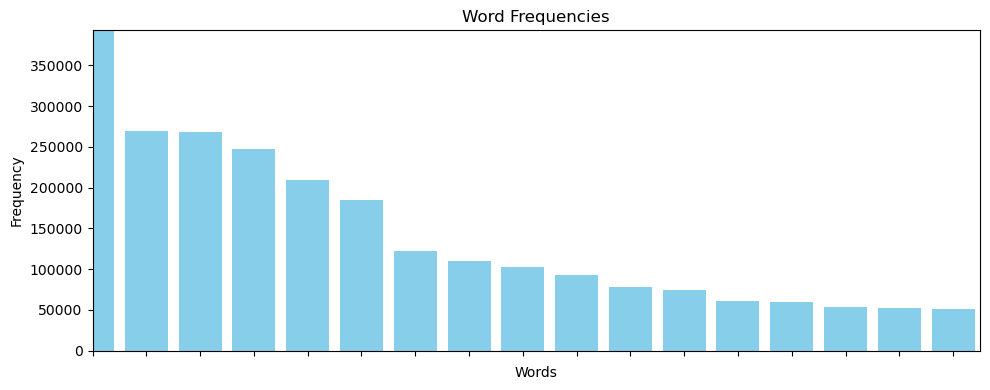

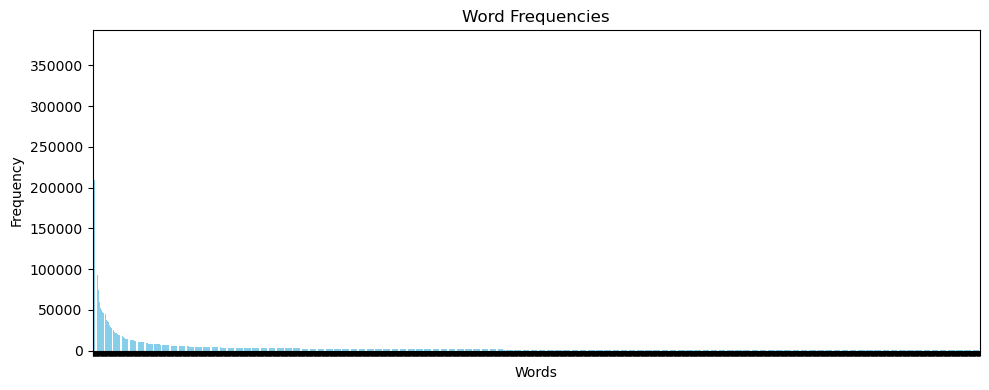

In [ ]:
plot_word_frequencies(most_frequent_100_raw)
plot_word_frequencies(most_frequent_10000_raw)

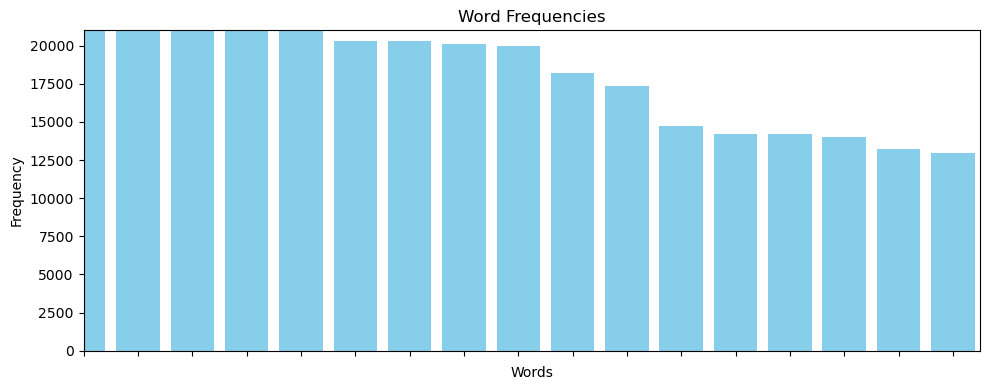

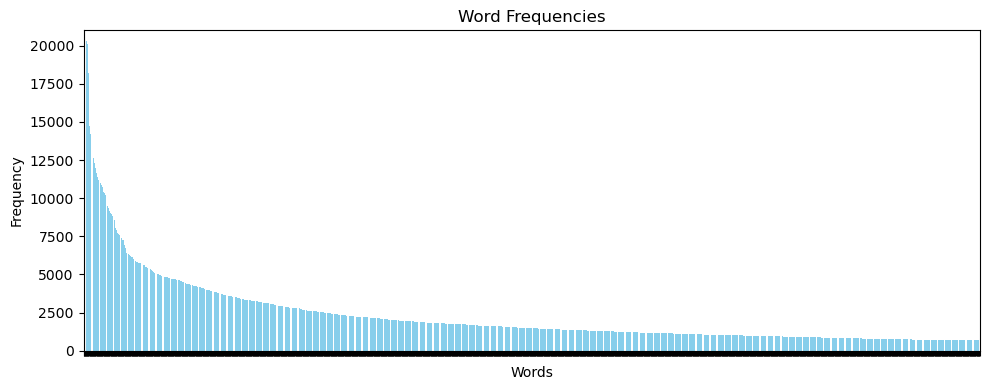

In [ ]:
plot_word_frequencies(most_frequent_100_stem)
plot_word_frequencies(most_frequent_10000_stem)

### Separating target values

In [ ]:
X = df2.drop(columns=['type'])
X['stems'] = stems
#X['stems'] = pd.Series(stems, index=df3.index)
y = df2['type'].dropna()
X = X.loc[y.index]  # Align X with y

print(X.size)
# Convert 'type' to binary values
y = y.apply(lambda x: 1 if x == 'reliable' else 0).rename(y.name)

print(X.columns)
print(X.shape)



457368
Index(['Unnamed: 0', 'id', 'domain', 'url', 'content', 'scraped_at',
       'inserted_at', 'updated_at', 'title', 'authors', 'keywords',
       'meta_keywords', 'meta_description', 'tags', 'summary', 'source',
       'url_count', 'date_count', 'num_count', 'total_words',
       'mean_word_length', 'unique_words_ratio', 'has_author', 'stems'],
      dtype='object')
(19057, 24)


### Splitting

In [231]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=0,stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0,stratify=y_temp)

# Count rows directly for each DataFrame
train_data_count = X_train.shape[0]
val_data_count = X_val.shape[0]
test_data_count = X_test.shape[0]

print("Train rows:", train_data_count)
print("Validation rows:", val_data_count)
print("Test rows:", test_data_count)


Train rows: 15245
Validation rows: 1906
Test rows: 1906


## Part 2: Logistic regression

### Feature Creation

In [232]:

# Creating word feature vector for each article

def create_word_features(stems_series, vocabulary):
    """Takes a pandas series of stemmed word lists and a vocabulary
        and returns a pandas dataframe of one-hot encoded word lists.

        Input: stem_series: pd.Series list str
        vocabulary: string dict
        
        Output: string dict
    """
    features = []
    for stems in stems_series:
        article_features = {word: 0 for word in vocabulary}
        if isinstance(stems, list):
            for word in stems:
                if word in vocabulary:
                    article_features[word] += 1
        features.append(list(article_features.values()))
    return pd.DataFrame(features, columns=vocabulary.keys())



### Logistic Model v1

In [233]:
# Training and testing the logistic regression model

def train_logistic_regression_with_vocabulary(X_train, X_val, X_test, y_train, y_val, y_test):
    
    # Create Vocabulary
    vocabulary = most_frequent_words(X_train['stems'])

    # Create Features
    X_train_features = create_word_features(X_train['stems'], vocabulary)
    X_val_features = create_word_features(X_val['stems'], vocabulary)
    X_test_features = create_word_features(X_test['stems'], vocabulary)

    # Train Logistic Regression
    model = LogisticRegression(solver='liblinear', random_state=0)
    model.fit(X_train_features, y_train)

    # Evaluate
    y_pred = model.predict(X_test_features)
    f1 = f1_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print(f"F1 Score: {round(f1,3)}\n")
    print("Classification Report:\n", report)

    return model


### Results

In [ ]:

print(X_train.columns)

model1 = train_logistic_regression_with_vocabulary(X_train, X_val, X_test, y_train, y_val, y_test)



Index(['Unnamed: 0', 'id', 'domain', 'url', 'content', 'scraped_at',
       'inserted_at', 'updated_at', 'title', 'authors', 'keywords',
       'meta_keywords', 'meta_description', 'tags', 'summary', 'source',
       'url_count', 'date_count', 'num_count', 'total_words',
       'mean_word_length', 'unique_words_ratio', 'has_author', 'stems'],
      dtype='object')


/opt/miniconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


F1 Score: 0.799

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.96      0.95      1477
           1       0.86      0.75      0.80       429

    accuracy                           0.92      1906
   macro avg       0.89      0.86      0.87      1906
weighted avg       0.91      0.92      0.91      1906



### Logistic Model v2

In [234]:
def train_logistic_regression_additional_features(X_train, X_val, X_test, y_train, y_val, y_test):
    
    # Create Vocabulary
    vocabulary = most_frequent_words(X_train['stems'])

    # Create Features from Vocabulary
    X_train_features = create_word_features(X_train['stems'], vocabulary)
    X_val_features = create_word_features(X_val['stems'], vocabulary)
    X_test_features = create_word_features(X_test['stems'], vocabulary)

    # Add additional features
    
    X_train_temp = pd.DataFrame(
        {
            'num_count': X_train['num_count'].values,
            'url_count': X_train['url_count'].values
        },
        index=X_train_features.index
    )
    
    X_val_temp = pd.DataFrame(
        {
            'num_count': X_val['num_count'].values,
            'url_count': X_val['url_count'].values
        },
        index=X_val_features.index
    )

    X_test_temp = pd.DataFrame(
        {
            'num_count': X_test['num_count'].values,
            'url_count': X_test['url_count'].values
        },
        index=X_test_features.index
    )

    X_train_af = pd.concat([X_train_features, X_train_temp], axis=1)
    X_val_af = pd.concat([X_val_features, X_val_temp], axis=1)
    X_test_af = pd.concat([X_test_features, X_test_temp], axis=1)

    # Train Logistic Regression
    model = LogisticRegression(solver='liblinear', random_state=42)
    model.fit(X_train_af, y_train)

    # Evaluate
    y_pred = model.predict(X_test_af)
    f1 = f1_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print(f"F1 Score: {round(f1,3)}\n")
    print("Classification Report:\n", report)


    return model

In [ ]:
model2 = train_logistic_regression_additional_features(X_train, X_val, X_test, y_train, y_val, y_test)

/opt/miniconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


F1 Score: 0.798

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95      1477
           1       0.86      0.74      0.80       429

    accuracy                           0.92      1906
   macro avg       0.90      0.85      0.87      1906
weighted avg       0.91      0.92      0.91      1906



### BBC articles

In [ ]:
df_bbc = pd.read_csv('/Users/david.joergensen/Documents/ProjectsVS/Data Science Course/Project/bbc_articles.csv')
df_bbc.shape
df_bbc

,Headline,Date,Author,Article text
0,Pelicots' daughter presses charges against fat...,2025-03-06,Laura Gozzi,"Caroline Darian, the daughter of Dominique and..."
1,France has a nuclear umbrella. Could its Europ...,2025-03-06,Hugh Schofield,So in the end Charles de Gaulle was right.\nA...
2,Trump celebrates Irish in America ahead of tao...,2025-03-07,Catherine Moore,US President Donald Trump has hailed the impac...
3,Denmark postal service to stop delivering letters,2025-03-06,Adrienne Murray & Paul Kirby,"Denmark's state-run postal service, PostNord, ..."
4,This city helped the US back Ukraine. Now its ...,2025-03-06,Kayla Epstein,US President Donald Trump's pause on military...
...,...,...,...,...
161,Rower rescued days before completing trans-Pac...,2025-03-03,Kelly Ng,An adventurer who tried to row across the Paci...
162,Headline not found.,Publication date not found.,Author not found.,NaN
163,Headline not found.,Publication date not found.,Author not found.,NaN
164,Australia host loses job over offensive women'...,2025-02-26,Simon Atkinson,An Australian radio presenter has left the net...


### Processing

In [ ]:
# Applying the processing pipeline

df_bbc['Article text'] = df_bbc['Article text'].fillna('')
df_bbc['Article text'] = df_bbc['Article text'].apply(clean_text_2)

tokens_BBC = df_bbc['Article text'].apply(nltk.word_tokenize).rename('tokens')
tokens_BBC = tokens_BBC.apply(filter_stopwords)

print(f'Size before stemming: {vocab_size_2(tokens_BBC)}')
stems_BBC = tokens_BBC.apply(stem).rename('stems')
print(f'Size after stemming: {vocab_size_2(stems_BBC)}')



Size before stemming: 5742
Size after stemming: 4339


### Merging with existing training data

In [ ]:

y_BBC = pd.Series([1] * len(stems_BBC))
y_train_new = pd.concat([y_train, y_BBC], axis=0)

X_train_new = pd.concat([X_train, stems_BBC], axis=0)

stems_BBC_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=0,stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0,stratify=y_temp)



### Result

In [ ]:

model3 = train_logistic_regression_with_vocabulary(X_train_new, X_val, X_test, y_train_new, y_val, y_test)





/opt/miniconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


F1 Score: 0.841

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95      1477
           1       0.85      0.83      0.84       429

    accuracy                           0.93      1906
   macro avg       0.90      0.89      0.90      1906
weighted avg       0.93      0.93      0.93      1906



## Part 3: Advanced Model

..........
..........

## Part 4: Evaluation

In [ ]:
df_ltest = pd.read_csv("/Users/david.joergensen/Documents/ProjectsVS/Data Science Course/Project/test.tsv", sep="\t")

print(df_ltest.iloc[:, 2])


(10239, 14)
(1283, 14)
0       Wisconsin is on pace to double the number of l...
1       Says John McCain has done nothing to help the ...
2       Suzanne Bonamici supports a plan that will cut...
3       When asked by a reporter whether hes at the ce...
4       Over the past five years the federal governmen...
                              ...                        
1261    Says his budget provides the highest state fun...
1262                      Ive been here almost every day.
1263    In the early 1980s, Sen. Edward Kennedy secret...
1264    Says an EPA permit languished under Strickland...
1265    Says the governor is going around the state ta...
Name: Building a wall on the U.S.-Mexico border will take literally years., Length: 1266, dtype: object


In [235]:

test_temp = df_ltest.iloc[:, 2].fillna('')
test_temp = test_temp.apply(clean_text_2)

tokens_test = test_temp.apply(nltk.word_tokenize).rename('tokens')
tokens_test = tokens_test.apply(filter_stopwords)

stems_test = tokens_test.apply(stem).rename('stems')

print(f'Size before stemming: {vocab_size_2(tokens_test)}')
print(f'Size after stemming: {vocab_size_2(stems_test)}')




Size before stemming: 4131
Size after stemming: 3189


In [240]:
y_test = df_ltest.iloc[:, 1]
print(y_test)

y_test = y_test.apply(lambda x: 1 if x in ['true', 'mostly-true', 'half-true'] else 0).rename(y_test.name)
print(y_test[0:300])

y.value_counts()

0             false
1             false
2         half-true
3        pants-fire
4              true
           ...     
1261      half-true
1262    barely-true
1263    barely-true
1264    barely-true
1265          false
Name: true, Length: 1266, dtype: object
0      0
1      0
2      1
3      0
4      1
      ..
295    0
296    1
297    1
298    0
299    0
Name: true, Length: 300, dtype: int64


type
0    14768
1     4289
Name: count, dtype: int64

In [238]:
X_test = stems_test.to_frame()

print(X_test)

                                                  stems
0        [wisconsin, pace, doubl, number, layoff, year]
1            [say, john, mccain, done, noth, help, vet]
2     [suzann, bonamici, support, plan, cut, choic, ...
3     [ask, report, whether, he, center, crimin, sch...
4     [past, five, year, feder, govern, paid, $, num...
...                                                 ...
1261  [say, budget, provid, highest, state, fund, le...
1262                          [ive, almost, everi, day]
1263  [earli, num, sen, edward, kennedi, secretli, o...
1264  [say, epa, permit, languish, strickland, new, ...
1265  [say, governor, go, around, state, talk, fund,...

[1266 rows x 1 columns]


In [239]:
model4 = train_logistic_regression_with_vocabulary(X_train, X_val, X_test, y_train, y_val, y_test)

/opt/miniconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


F1 Score: 0.0

Classification Report:
               precision    recall  f1-score   support

           0       0.44      1.00      0.61       553
           1       0.00      0.00      0.00       713

    accuracy                           0.44      1266
   macro avg       0.22      0.50      0.30      1266
weighted avg       0.19      0.44      0.27      1266



/opt/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
